# Lab 11: Long Short Term Memory (LSTM) Models
# st121395 | Chanapa Pananookooln

Today we will build a chatbot using the PyTorch LSTM cell.

For the homework we need to find other dataset and train a chatbot with the same code.

The dataset I chose is the MultiWOZ dataset.

Multi-Domain Wizard-of-Oz dataset (MultiWOZ), a fully-labeled collection of human-human written conversations spanning over multiple domains and topics. At a size of 10k dialogues, it is at least one order of magnitude larger than all previous annotated task-oriented corpora.

Each dialogue consists of a goal, multiple user and system utterances as well as a belief state.

I used MultiWOZ 2.2.

This dataset consists of a schema file schema.json describing the ontology and dialogue files dialogues_*.json of dialogue data under the train, dev, and test folders.

I only took the data from the train folder to do this lab.

## Download all train json files

In [ ]:
# for i in ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016','017']:
#     !wget 'https://raw.githubusercontent.com/budzianowski/multiwoz/master/data/MultiWOZ_2.2/train/dialogues_{i}.json'
#     !mv 'dialogues_{i}.json' '../../data/multiwoz/'

## Get the dialogue from all json files in the train folder and combine them into a Dataframe

In [3]:
# import json
# import pandas as pd
  
# for i in ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016','017']:
#     if i =='001':
#         f = open(f'../../data/multiwoz/dialogues_{i}.json')
#         data = json.load(f)
#         all_question, all_answer = [], []

#         for qa in data:
#             all_question.append(qa[u'turns'][0][u'utterance'])
#             all_answer.append(qa[u'turns'][1][u'utterance'])

#             all_ = pd.DataFrame([all_question,all_answer]).T

#     else : 
#         f = open(f'../../data/multiwoz/dialogues_{i}.json')
#         data = json.load(f)
#         all_question, all_answer = [], []

#         for qa in data:
#             all_question.append(qa[u'turns'][0][u'utterance'])
#             all_answer.append(qa[u'turns'][1][u'utterance'])

#         new = pd.DataFrame([all_question,all_answer]).T

#         all_ = pd.concat([all_, new], axis=0)

In [4]:
# all_

,0,1
0,i need a place to dine in the center thats exp...,I have several options for you; do you prefer ...
1,"Guten Tag, I am staying overnight in Cambridge...",I have 4 different options for you. I have two...
2,Hi there! Can you give me some info on Cityroomz?,"Cityroomz is located at Sleeperz Hotel, Statio..."
3,I am looking for a hotel named alyesbray lodge...,"i have their info, what would you like to know?"
4,i need a train on tuesday out of kings lynn,What time of day would you like to leave?
...,...,...
241,I would like to visit some of the architecture...,I can indeed. We have several churches and a s...
242,"Hi, can you help me find a moderately priced 3...",I have 4 guesthouses with 3 stars that are mod...
243,Hi! I am looking for a train that arrives by 1...,I have 122 trains that are arriving by 11:30. ...
244,I would like the phone number of an expensive ...,There are five restaurants in the expensive pr...


## Save as txt file

In [ ]:
# import numpy as np

# np.savetxt(r'../../data/hotpotqa/multiwoz_all.txt', all.values, fmt='%s', delimiter='\t')

## LSTM architecture

In [1]:
import torch
from torch import nn

class NaiveCustomLSTM(nn.Module):
    
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        # Parameters for computing i_t
        self.U_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing f_t
        self.U_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing c_t
        self.U_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))
        
        # Parameters for computing o_t
        self.U_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, init_states=None):
        """
        forward: Run input x through the cell. Assumes x.shape is (batch_size, sequence_length, input_size)
        """
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            h_t, c_t = init_states
            
        for t in range(seq_sz):
            x_t = x[:, t, :]
            
            i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
            f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
            g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
            o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            hidden_seq.append(h_t.unsqueeze(0))
        
        # Reshape hidden_seq tensor to (batch size, sequence length, hidden_size)
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq, (h_t, c_t)

## Building our chatbot with Greedy Search

In [2]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pickle
from torch.autograd import Variable
from get_free_gpu import get_free_gpu

CUDA = torch.cuda.is_available()
device = get_free_gpu()

### Load and preprocess the data

In [3]:
# Reserved word tokens

PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:

    def __init__(self):        
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold

    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries

        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [4]:
MAX_LENGTH = 30  # Maximum sentence length to consider *** The sentences in this dataset is very long so I changed this

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a Voc object

def readVocs(datafile):
    print("Reading lines...")    
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc()
    return voc, pairs

# Boolean function returning True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold

def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using the filterPair predicate

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list

def loadPrepareData(datafile):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs

## Load data into voc object

In [5]:
# Load/Assemble Voc and pairs

datafile = '../../data/multiwoz/multiwoz_all.txt'
voc, pairs = loadPrepareData(datafile)

# Print some pairs to validate

print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 6389 sentence pairs
Trimmed to 5998 sentence pairs
Counting words...
Counted words: 2220

pairs:
['hello ! i am looking for the address and phone number of a lebanese restaurant in the centre .', 'ali baba is a lebanese restaurant in the centre area . its address is hills road city . phone number is']
['i m looking for a train from london liverpool street .', 'i have many trains that leave from london liverpool street . when would you like to leave ?']
['yes i am planning a trip and could use some information on attractions .', 'i can help you with that ! what type of attraction are you looking for ?']
['i need help i have robbed', 'please contact the parkside cambridge police station']
['i am looking for a particular hotel . its name is called arbury lodge guesthouse', 'would you like me to check availability for arbury lodge guesthouse on a particular date ?']
['can i find the parkside police station', 'the parkside police stati

As already mentioned, we will trim out rarely-used
words from the vocabulary. This will help improve convergence during
training, because with a lower-dimensional input feature space, it will be easier
to estimate the probability model $P(y \mid x)$. We trim as a two-step
process:

1. Trim words appearing fewer than `MIN_COUNT` times with the previously-given `Voc.trim`
   method.

2. Filter out all sentence pairs containing trimmed words.

In [6]:
MIN_COUNT = 2    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs

# Trim vocabulary and pairs

pairs_ = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 1535 / 2217 = 0.6924
Trimmed from 5998 pairs to 5417, 0.9031 of total


### Split dataset into testing and training pair sets

In [7]:
testpairs = pairs_[5000:]
pairs  = pairs_[:5000]

print(len(pairs))
print(len(testpairs))

5000
417


### Convert pairs to tensors

In [8]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Return a padded input sequence tensor and the lengths of each original sequence

def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Return a padded target sequence tensor, a padding mask, and the max target length

def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Return all items for a given batch of pairs

def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

# Example for validation

small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

As LSTM takes time series data so we need to convert our pairs of sentences into time series.

In [13]:
pair_batch = pairs[:5]
print(pair_batch) # sentence pairs

pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)

print("============ Target Variable ==============")
print(target_variable)
print("============ Mask ==============")
print(mask)
print("============ Max Target Len ==============")
print(max_target_len)

[['hello ! i am looking for the address and phone number of a lebanese restaurant in the centre .', 'ali baba is a lebanese restaurant in the centre area . its address is hills road city . phone number is'], ['i m looking for a train from london liverpool street .', 'i have many trains that leave from london liverpool street . when would you like to leave ?'], ['yes i am planning a trip and could use some information on attractions .', 'i can help you with that ! what type of attraction are you looking for ?'], ['i need help i have robbed', 'please contact the parkside cambridge police station'], ['i am looking for a particular hotel . its name is called arbury lodge guesthouse', 'would you like me to check availability for arbury lodge guesthouse on a particular date ?']]
============ Target Variable ==============
tensor([[  5,   5,  85,   5,   5],
        [ 35,  35,  42,  35,  35],
        [368, 309,  35, 132,  36],
        [  8,  53,  92,  37,  37],
        [ 37,   9, 101,  38,  38

### Define models
Seq2Seq Model

#### Encoder

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.gru = nn.LSTM(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        
        embedded = self.embedding(input_seq)

        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths.cpu())
        
        outputs, hidden = self.gru(packed, hidden)
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        
        return outputs, hidden
    
    def init_hidden(self):  
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

#### Attention weights

In [11]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        
    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def forward(self, hidden, encoder_outputs):
        attn_energies = self.dot_score(hidden, encoder_outputs)
        attn_energies = attn_energies.t()
        return F.softmax(attn_energies, dim=1).unsqueeze(1)   

#### Decoder with attention

In [12]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))#, bidirectional=True)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, input_step, last_hidden, encoder_outputs):
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        rnn_output, hidden = self.gru(embedded, last_hidden)
        
        attn_weights = self.attn(rnn_output, encoder_outputs)
        
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        return output, hidden

### Training procedure

Masked loss

In [13]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

### Train function
with With teacher forcing and gradient clipping

In [14]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    loss = 0
    print_losses = []
    n_totals = 0

    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)
    
    decoder_hidden = encoder_hidden[:decoder.n_layers]
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            decoder_input = target_variable[t].view(1, -1)
            
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    loss.backward()

    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

## Full training procedure

In [15]:
 max_target_len 

27

In [16]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    losslist = []
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0
            losslist.append(print_loss_avg)
        
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            print(directory)
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))
    return losslist

#### Greedy decoder

In [17]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
       
        for _ in range(max_length):
            
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            
            decoder_input = torch.unsqueeze(decoder_input, 0)
        
        return all_tokens, all_scores

#### Evaluating some text

In [18]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
  
    indexes_batch = [indexesFromSentence(voc, sentence)]
    
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    
    tokens, scores = searcher(input_batch, lengths, max_length)
    
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            
            input_sentence = input('> ')
            
            if input_sentence == 'q' or input_sentence == 'quit': break
            
            input_sentence = normalizeString(input_sentence)
            
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

## Run Model

In [19]:
model_name = 'cb_model'
attn_model = 'dot'

hidden_size = 512
encoder_n_layers = 2
decoder_n_layers = 4
dropout = 0.5
batch_size = 256 
loadFilename = None

embedding = nn.Embedding(voc.num_words, hidden_size)
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
encoder = encoder.to(device)
decoder = decoder.to(device)

In [20]:
save_dir = 'content/'
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 6000
print_every = 10
save_every = 2000
loadFilename = None
corpus_name="Chat"
encoder.train()
decoder.train()
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
print("Starting Training!")
lossvalues = trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Starting Training!
Initializing ...
Training...
ipykernel_launcher:4: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
Iteration: 10; Percent complete: 0.2%; Average loss: 6.9168
Iteration: 20; Percent complete: 0.3%; Average loss: 5.4861
Iteration: 30; Percent complete: 0.5%; Average loss: 5.0905
Iteration: 40; Percent complete: 0.7%; Average loss: 5.0543
Iteration: 50; Percent complete: 0.8%; Average loss: 4.9184
Iteration: 60; Percent complete: 1.0%; Average loss: 4.8833
Iteration: 70; Percent complete: 1.2%; Average loss: 4.8074
Iteration: 80; Percent complete: 1.3%; Average loss: 4.7451
Iteration: 90; Percent complete: 1.5%; Average loss: 4.6761
Iteration: 100; Percent complete: 1.7%; Average loss: 4.6368
Iteration: 110; Percent complete: 1.8%; Average loss: 4.5569
Iteration: 120; Percent complete: 2.0%; Average loss: 4.5316
Iteration: 130; Percent com

## Plot graph

In [21]:
import matplotlib.pyplot as plt
plt.plot(lossvalues)
plt.show()

## **Bleu score Calculation** 

In [22]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction


searcher = GreedySearchDecoder(encoder, decoder)
gram1_bleu_score = []
gram2_bleu_score = []
for i in range(0,len(testpairs),1):
  
      input_sentence = testpairs[i][0]

      reference = testpairs[i][1:]
      templist = []
      for k in range(len(reference)):
        if(reference[k]!=''):
          temp = reference[k].split(' ')
          templist.append(temp)


      input_sentence = normalizeString(input_sentence)
      output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
      output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
      chencherry = SmoothingFunction()
    #   print(output_words)
    #   print(templist)
      score1 = sentence_bleu(templist,output_words,weights=(1, 0, 0, 0) ,smoothing_function=chencherry.method1)
      score2 = sentence_bleu(templist,output_words,weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1) 
      gram1_bleu_score.append(score1)
      gram2_bleu_score.append(score2)
      if i%1000 == 0:
        print(i,sum(gram1_bleu_score)/len(gram1_bleu_score),sum(gram2_bleu_score)/len(gram2_bleu_score))
print("Total Bleu Score for 1 grams on testing pairs: ", sum(gram1_bleu_score)/len(gram1_bleu_score) )  
print("Total Bleu Score for 2 grams on testing pairs: ", sum(gram2_bleu_score)/len(gram2_bleu_score) )

0 0.18518518518518515 0.02668802563418119
Total Bleu Score for 1 grams on testing pairs:  0.269192600205076
Total Bleu Score for 2 grams on testing pairs:  0.1459588921461553


In [23]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

# ME : I'm looking for a restaurant.
# Bot: what type of food would you like ? asian oriental ? what area ? is available centre .
# ME : I'm looking for a place to stay.
# Bot: what price range and in what area would you like to stay ? wifi ? wifi town . parking ? is a priced rating .
# ME : I need a lift.
# Error: Encountered unknown word.

Bot: what type of food would you like ? asian oriental ? what area ? is available centre .
Bot: what price range and in what area would you like to stay ? wifi ? wifi town . parking ? is a priced rating .
Error: Encountered unknown word.


KeyboardInterrupt: Interrupted by user

## Beam search

## **Beam Decoder**

The difference between greedy search and beam search is decoder function. Thus, greedy search function name is greedy_decode, and beam search function name is beam_decode.

In [24]:
class Sentence:
    def __init__(self, decoder_hidden, last_idx=SOS_token, sentence_idxes=[], sentence_scores=[]):
        if(len(sentence_idxes) != len(sentence_scores)):
            raise ValueError("length of indexes and scores should be the same")
        self.decoder_hidden = decoder_hidden
        self.last_idx = last_idx
        self.sentence_idxes =  sentence_idxes
        self.sentence_scores = sentence_scores

    def avgScore(self):
        if len(self.sentence_scores) == 0:
            raise ValueError("Calculate average score of sentence, but got no word")
        # return mean of sentence_score
        return sum(self.sentence_scores) / len(self.sentence_scores)

    def addTopk(self, topi, topv, decoder_hidden, beam_size, voc):
        topv = torch.log(topv)
        terminates, sentences = [], []
        for i in range(beam_size):
            if topi[0][i] == EOS_token:
                terminates.append(([voc.index2word[idx.item()] for idx in self.sentence_idxes] + ['<EOS>'],
                                   self.avgScore())) 
                continue
            idxes = self.sentence_idxes[:] 
            scores = self.sentence_scores[:] 
            idxes.append(topi[0][i])
            scores.append(topv[0][i])
            sentences.append(Sentence(decoder_hidden, topi[0][i], idxes, scores))
        return terminates, sentences

    def toWordScore(self, voc):
        
        words = []
        for i in range(len(self.sentence_idxes)):
            if self.sentence_idxes[i] == EOS_token:
                words.append('<EOS>')
            else:
                words.append(voc.index2word[self.sentence_idxes[i].item()])
       
        if self.sentence_idxes[-1] != EOS_token:
            words.append('<EOS>')
        return (words, self.avgScore())

    def __repr__(self):
        res = f"Sentence with indices {self.sentence_idxes} "
        res += f"and scores {self.sentence_scores}"
        return res
    
def beam_decode(decoder, decoder_hidden, encoder_outputs, voc, beam_size, max_length=MAX_LENGTH):
    terminal_sentences, prev_top_sentences, next_top_sentences = [], [], []
    prev_top_sentences.append(Sentence(decoder_hidden))
    for i in range(max_length):
        
        for sentence in prev_top_sentences:
            decoder_input = torch.LongTensor([[sentence.last_idx]])
            decoder_input = decoder_input.to(device)

            decoder_hidden = sentence.decoder_hidden
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(beam_size)
            term, top = sentence.addTopk(topi, topv, decoder_hidden, beam_size, voc)
            terminal_sentences.extend(term)
            next_top_sentences.extend(top)
           
        
        next_top_sentences.sort(key=lambda s: s.avgScore(), reverse=True)
        prev_top_sentences = next_top_sentences[:beam_size]
        next_top_sentences = []
        

    terminal_sentences += [sentence.toWordScore(voc) for sentence in prev_top_sentences]
    terminal_sentences.sort(key=lambda x: x[1], reverse=True)

    n = min(len(terminal_sentences), 15)
    return terminal_sentences[:n]



class BeamSearchDecoder(nn.Module):

    def __init__(self, encoder, decoder, voc, beam_size=10):
        super(BeamSearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.voc = voc
        self.beam_size = beam_size

    def forward(self, input_seq, input_length, max_length):
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]
        
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        sentences = beam_decode(self.decoder, decoder_hidden, encoder_outputs, self.voc, self.beam_size, max_length)
        
        
        all_tokens = [torch.tensor(self.voc.word2index.get(w, 0)) for w in sentences[0][0]]
        return all_tokens, None

    def __str__(self):
        res = f"BeamSearchDecoder with beam size {self.beam_size}"
        return res


In [25]:
model_name = 'cb_model'
attn_model = 'dot'

hidden_size = 512
encoder_n_layers = 2
decoder_n_layers = 4
dropout = 0.5
batch_size = 256 
loadFilename = None

embedding = nn.Embedding(voc.num_words, hidden_size)
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
encoder = encoder.to(device)
decoder = decoder.to(device)

In [26]:
save_dir = 'content/'
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 6000
print_every = 10
save_every = 2000
loadFilename = None
corpus_name="Chat"
encoder.train()
decoder.train()
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
print("Starting Training!")
lossvalues = trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Starting Training!
Initializing ...
Training...
ipykernel_launcher:4: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
Iteration: 10; Percent complete: 0.2%; Average loss: 6.9570
Iteration: 20; Percent complete: 0.3%; Average loss: 5.5268
Iteration: 30; Percent complete: 0.5%; Average loss: 5.0958
Iteration: 40; Percent complete: 0.7%; Average loss: 4.9760
Iteration: 50; Percent complete: 0.8%; Average loss: 4.8879
Iteration: 60; Percent complete: 1.0%; Average loss: 4.8355
Iteration: 70; Percent complete: 1.2%; Average loss: 4.7691
Iteration: 80; Percent complete: 1.3%; Average loss: 4.6698
Iteration: 90; Percent complete: 1.5%; Average loss: 4.6232
Iteration: 100; Percent complete: 1.7%; Average loss: 4.5372
Iteration: 110; Percent complete: 1.8%; Average loss: 4.4451
Iteration: 120; Percent complete: 2.0%; Average loss: 4.4164
Iteration: 130; Percent com

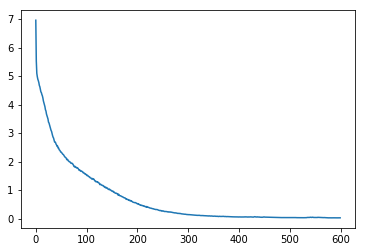

In [27]:
import matplotlib.pyplot as plt

plt.plot(lossvalues)
plt.show()

## **Bleu score Calculation** 

In [28]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

############################################################################
# Difference between greedy search and beam search is here

# greedy search
# searcher = GreedySearchDecoder(encoder, decoder)

# beam search
searcher = BeamSearchDecoder(encoder, decoder, voc, 10)
############################################################################
gram1_bleu_score = []
gram2_bleu_score = []
for i in range(0,len(testpairs),1):
  
  input_sentence = testpairs[i][0]
  
  reference = testpairs[i][1:]
  templist = []
  for k in range(len(reference)):
    if(reference[k]!=''):
      temp = reference[k].split(' ')
      templist.append(temp)
  
  
  input_sentence = normalizeString(input_sentence)
  output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
  output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
  chencherry = SmoothingFunction()
  score1 = sentence_bleu(templist,output_words,weights=(1, 0, 0, 0) ,smoothing_function=chencherry.method1)
  score2 = sentence_bleu(templist,output_words,weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1) 
  gram1_bleu_score.append(score1)
  gram2_bleu_score.append(score2)
  if i%1000 == 0:
    print(i,sum(gram1_bleu_score)/len(gram1_bleu_score),sum(gram2_bleu_score)/len(gram2_bleu_score))
print("Total Bleu Score for 1 grams on testing pairs: ", sum(gram1_bleu_score)/len(gram1_bleu_score))  
print("Total Bleu Score for 2 grams on testing pairs: ", sum(gram2_bleu_score)/len(gram2_bleu_score))  

0 0.26053876229906775 0.17615635478300695
Total Bleu Score for 1 grams on testing pairs:  0.2700490149407549
Total Bleu Score for 2 grams on testing pairs:  0.15171761474908782


## **Chatting with BOT / Evaluation**
Lets do chat with our newly trained chatbot

In [29]:
encoder.eval()
decoder.eval()
searcher = BeamSearchDecoder(encoder, decoder, voc, 10)
evaluateInput(encoder, decoder, searcher, voc)

# Me : I'm looking for a restaurant.
# Bot: what area of town do you want ?
# Me : I'm looking for a place to stay
# Bot: we have options any preference in options
# Me : I need a ride.
# Bot: sure . i can help you with that .

KeyboardInterrupt: Interrupted by user

# Conclusion

In this lab we learned about LSTM and all of its equations in action.

Then we use LSTM cells in a model called seq2seq. The seq2seq model consists of encoder and decoder network both of which includes LSTM cells. The encoder encode sequence of words and embed them as a representation then the decoder takes the embedded representation and decode another sequence of words. We use this architecture to make a chat bot where it takes a sentence as input and output a response or answer.

There are 2 search algorithm we can use in the decoder part. First is the greedy search which choose the word with maximum probability at every step but might not end up with the optimum sentence. Second is beam search which adds the k candidate to the greedy search.

The first part we trained a chatbot from a movie dialogue corpus and for the homework I trained a chatbot with real a human-human conversations.

# Inference : Chat with our Chatbot

In [2]:
#%%
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pickle
from torch.autograd import Variable
from get_free_gpu import get_free_gpu

import train_eval_loss
from model import EncoderRNN, Attn, LuongAttnDecoderRNN, GreedySearchDecoder, Sentence, beam_decode, BeamSearchDecoder
from lstm_cell import NaiveCustomLSTM
import preprocess
from preprocess import Voc

CUDA = torch.cuda.is_available()
device = get_free_gpu()

print("Finished importing...")

# global MAX_LENGTH, MIN_COUNT, PAD_token, SOS_token, EOS_token
MAX_LENGTH = 30
MIN_COUNT = 2 
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

#%%
from preprocess import loadPrepareData
datafile = '../../data/multiwoz/multiwoz_all.txt'
voc, pairs = loadPrepareData(datafile, MAX_LENGTH)

# Print some pairs to validate
# print("\npairs:")
# for pair in pairs[:10]:
#     print(pair)

#%%
# Trim vocabulary and pairs
from preprocess import trimRareWords
pairs_ = trimRareWords(voc, pairs, MIN_COUNT)

testpairs = pairs_[5000:]
pairs  = pairs_[:5000]

print(len(pairs))
print(len(testpairs))

#%%
from preprocess import batch2TrainData
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)], PAD_token)
input_variable, lengths, target_variable, mask, max_target_len = batches

#%%
# pair_batch = pairs[:5]
# print(pair_batch)
# pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
# print(pair_batch)
# print(target_variable)
# print(mask)
# print(max_target_len)

print("Finished preprocessing...")

#%%
model_name = 'cb_model'
attn_model = 'dot'

hidden_size = 512
encoder_n_layers = 2
decoder_n_layers = 4
dropout = 0.5
batch_size = 256 
loadFilename = None

embedding = nn.Embedding(voc.num_words, hidden_size)
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)

saved_dict = torch.load('content/cb_model/MultiWOZ/en2-de4_greedy/6000_checkpoint.tar')
# saved_dict = torch.load('content/cb_model/MultiWOZ/en2-de4_beam/6000_checkpoint.tar')

embedding.load_state_dict(saved_dict['embedding'])
encoder.load_state_dict(saved_dict['en'])
decoder.load_state_dict(saved_dict['de'])

encoder = encoder.to(device)
decoder = decoder.to(device)

#%%
learning_rate = 0.0001
decoder_learning_ratio = 5.0

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

encoder_optimizer.load_state_dict(saved_dict['en_opt'])
decoder_optimizer.load_state_dict(saved_dict['de_opt'])

print("Finished setup...")
#%%

from train_eval_loss import evaluateInput
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder, device)
# searcher = BeamSearchDecoder(encoder, decoder, voc, device, 10)
print("Evaluating...")
# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc, device, SOS_token, MAX_LENGTH, EOS_token)
# %%


Finished importing...
Start preparing training data ...
Reading lines...
Read 6389 sentence pairs
Trimmed to 5998 sentence pairs
Counting words...
Counted words: 2220
keep_words 1535 / 2217 = 0.6924
Trimmed from 5998 pairs to 5417, 0.9031 of total
5000
417
Finished preprocessing...
Finished setup...
Evaluating...


>  I am looking for a restaurant


Bot: what area of town could you like to dine at ? what area ? ! ! ! ! ! ! !


>  Thank you


Bot: of course . is there a particular area of town you are interested in ? ? ! . more information ? do you have


KeyboardInterrupt: 